In [56]:
import pandas as pd
from sklearn.metrics import confusion_matrix as sk_cm
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report

In [57]:
pred_path = "../logs/val_res/model_pred.csv"
df = pd.read_csv(pred_path)

## 1. Confusion matrix

In [54]:
print(df.pred.value_counts())
print("*"*10)
print(df.diagnosis.value_counts())

2    50056
0     3887
Name: pred, dtype: int64
**********
0    39714
2     7961
1     3799
4     1236
3     1233
Name: diagnosis, dtype: int64


In [55]:
gt = df.diagnosis.tolist()
pred = df.pred.tolist()

In [40]:
cm_matrix = sk_cm(gt, pred)

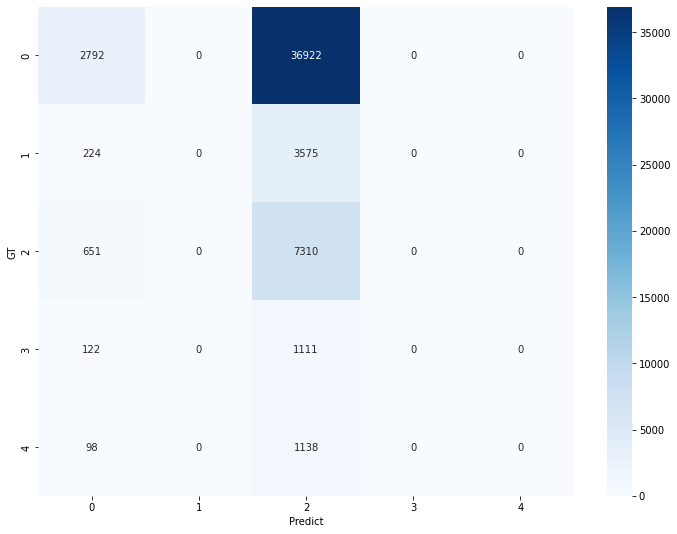

In [41]:
plt.figure(figsize=(12, 9))
sns.heatmap(cm_matrix, annot=True,fmt='g', cmap='Blues');
plt.xlabel("Predict");
plt.ylabel("GT");

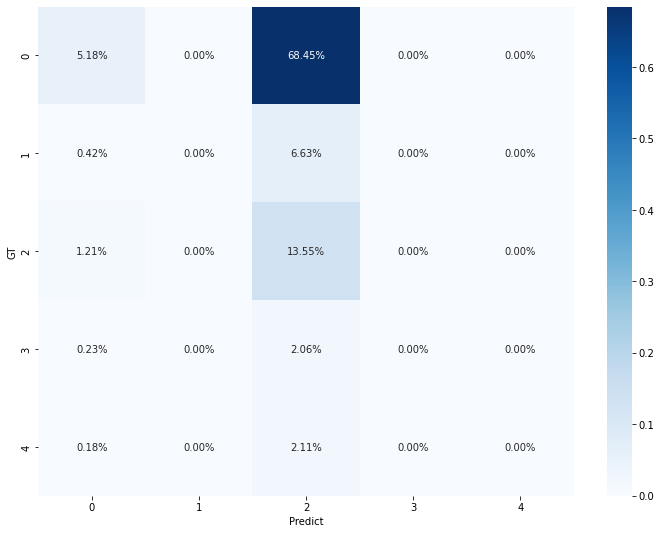

In [42]:
plt.figure(figsize=(12, 9))
sns.heatmap(cm_matrix/np.sum(cm_matrix), annot=True, fmt='.2%', cmap='Blues');
plt.xlabel("Predict");
plt.ylabel("GT");

## 2. F1-score, Precision, Accuracy

In [43]:
recall_score(gt, pred, average='macro')

0.1977058035042249

In [44]:
recall_score(gt, pred, average='micro')

0.18727174980998462

In [45]:
recall_score(gt, pred, average='weighted')

0.18727174980998462

In [46]:
recall_score(gt, pred, average=None)

array([0.07030266, 0.        , 0.91822635, 0.        , 0.        ])

In [52]:
print(classification_report(gt, pred));

              precision    recall  f1-score   support

           0       0.72      0.07      0.13     39714
           1       0.00      0.00      0.00      3799
           2       0.15      0.92      0.25      7961
           3       0.00      0.00      0.00      1233
           4       0.00      0.00      0.00      1236

    accuracy                           0.19     53943
   macro avg       0.17      0.20      0.08     53943
weighted avg       0.55      0.19      0.13     53943



/home/hmi/anaconda3/envs/aptos/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hmi/anaconda3/envs/aptos/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hmi/anaconda3/envs/aptos/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 3. Quadratic Weighted Kappa

In [47]:
def confusion_matrix(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Returns the confusion matrix between rater's ratings
    """
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(rater_a + rater_b)
    if max_rating is None:
        max_rating = max(rater_a + rater_b)
    num_ratings = int(max_rating - min_rating + 1)
    conf_mat = [[0 for i in range(num_ratings)]
                for j in range(num_ratings)]
    for a, b in zip(rater_a, rater_b):
        conf_mat[a - min_rating][b - min_rating] += 1
    return conf_mat


def histogram(ratings, min_rating=None, max_rating=None):
    """
    Returns the counts of each type of rating that a rater made
    """
    if min_rating is None:
        min_rating = min(ratings)
    if max_rating is None:
        max_rating = max(ratings)
    num_ratings = int(max_rating - min_rating + 1)
    hist_ratings = [0 for x in range(num_ratings)]
    for r in ratings:
        hist_ratings[r - min_rating] += 1
    return hist_ratings


def quadratic_weighted_kappa(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Calculates the quadratic weighted kappa
    quadratic_weighted_kappa calculates the quadratic weighted kappa
    value, which is a measure of inter-rater agreement between two raters
    that provide discrete numeric ratings.  Potential values range from -1
    (representing complete disagreement) to 1 (representing complete
    agreement).  A kappa value of 0 is expected if all agreement is due to
    chance.
    quadratic_weighted_kappa(rater_a, rater_b), where rater_a and rater_b
    each correspond to a list of integer ratings.  These lists must have the
    same length.
    The ratings should be integers, and it is assumed that they contain
    the complete range of possible ratings.
    quadratic_weighted_kappa(X, min_rating, max_rating), where min_rating
    is the minimum possible rating, and max_rating is the maximum possible
    rating
    """
    rater_a = np.array(rater_a, dtype=int)
    rater_b = np.array(rater_b, dtype=int)
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(min(rater_a), min(rater_b))
    if max_rating is None:
        max_rating = max(max(rater_a), max(rater_b))
    conf_mat = confusion_matrix(rater_a, rater_b,
                                min_rating, max_rating)
    num_ratings = len(conf_mat)
    num_scored_items = float(len(rater_a))

    hist_rater_a = histogram(rater_a, min_rating, max_rating)
    hist_rater_b = histogram(rater_b, min_rating, max_rating)

    numerator = 0.0
    denominator = 0.0

    for i in range(num_ratings):
        for j in range(num_ratings):
            expected_count = (hist_rater_a[i] * hist_rater_b[j]
                              / num_scored_items)
            d = pow(i - j, 2.0) / pow(num_ratings - 1, 2.0)
            numerator += d * conf_mat[i][j] / num_scored_items
            denominator += d * expected_count / num_scored_items

    return 1.0 - numerator / denominator

In [48]:
qwk = quadratic_weighted_kappa(gt, pred)

In [49]:
print(qwk)

-0.005949729311428786
